In [176]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [141]:
df = pd.DataFrame.from_csv("omit/ai2_data.csv")
df = df.fillna(0) #replacing NaN w/ 0

In [139]:
#Functions for data manipulation

#Given dataframe, return dataframe w/ new column col_name that sums given features
def add_agg_column(df_inp, col_name, features):
    df = df_inp.copy()
    df[col_name] = 0 #defining column
    index = 0;
    for row in df[features].iterrows(): #iterating through rows
        val = int(sum(row[1].values))
        df.loc[index, col_name] = val
        index = index+1
    return df

# given path to 2 column csv, return dictionary where key is first col
# key_as_first: true if first col is key (false is 2nd is)
# 1st col: component/block name
# 2nd col: component/block category
def csv_to_dict(path, key_as_first=True):
    reader = csv.reader(open(path, 'r'))
    d = {}
    for row in reader:
        if key_as_first:
            k, v = row
            d[k] = v
        else:
            v, k = row
            if k in d:
                d[k]+=[v] #add to list
            else:
                d[k]=[v]
    return d

def add_groups_col(df_inp):
    col_name = 'palette_groups'
    col_name_counter = 'num_palette_groups'
    col_basic = 'agg_ui'
    agg_groups = ['agg_lego', 'agg_media', 'agg_storage', 
                'agg_connect', 'agg_social', 'agg_sensor', 'agg_drawing']
    df = df_inp.copy()
    
    df[col_name] = "" #defining column
    df[col_name_counter] = 0 #defining column
    
    index = 0;
    for ind, row in df.iterrows(): #iterating through rows
        groups = ""
        num_counter = 0
        for grp in agg_groups:
            if row[grp]>0:
                groups+=grp[4:]+","
        if len(groups)>0:    
            df.loc[index, col_name] = groups[:-1] #removing trailing comma
            df.loc[index, col_name_counter] = len(groups[:-1].split(","))
        else:
            df.loc[index, col_name]= col_basic[4:]
            df.loc[index, col_name_counter] = 1
        index = index+1
    return df

In [77]:
cat_to_comps = csv_to_dict("component_category.csv", False)
cat_to_comps.pop('layout')
# comp_to_cat = csv_to_dict("component_category.csv", True) #maps component to category
# cat_to_comps['sensor']

['c_HorizontalArrangement', 'c_TableArrangement', 'c_VerticalArrangement']

In [142]:
#adding aggregate columns for palette groups
agg_cols = []
for key in cat_to_comps:
    agg_cols.append('agg_'+key)
    df = add_agg_column(df, 'agg_'+key, cat_to_comps[key])

#adding 'num_palette_groups', 'palette_groups' columns
df = add_groups_col(df)

df[agg_cols+['num_palette_groups', 'palette_groups']].head(5)


,agg_lego,agg_media,agg_storage,agg_ui,agg_connect,agg_social,agg_sensor,agg_drawing,num_palette_groups,palette_groups
0,0,0,0,1,0,0,1,1,2,"sensor,drawing"
1,0,0,0,0,0,0,0,1,1,drawing
2,0,0,0,1,0,0,0,0,1,ui
3,0,0,0,4,0,0,1,1,2,"sensor,drawing"
4,0,0,0,1,0,0,0,1,1,drawing


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10c068a50>]], dtype=object)

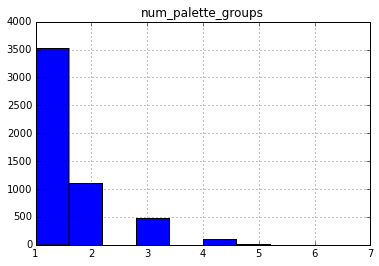

In [149]:
df[['num_palette_groups']].hist()
# df[df.num_palette_groups>1]['num_palette_groups'].hist()

ui                        1701
media                      722
drawing                    564
sensor,drawing             334
media,sensor               299
media,sensor,drawing       269
connect                    174
media,drawing              160
sensor                     159
storage                    131
connect,sensor              90
storage,connect,sensor      67
social                      61
storage,sensor              59
media,connect               29
...
lego,media,connect,social,sensor               2
lego,media,storage,connect,sensor              1
media,connect,drawing                          1
lego,media,drawing                             1
lego,media                                     1
media,storage,connect,social,sensor,drawing    1
lego,sensor                                    1
lego,media,storage                             1
lego,storage,sensor                            1
lego,storage,connect,social                    1
lego,media,connect,social                

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12502b3d0>], dtype=object)

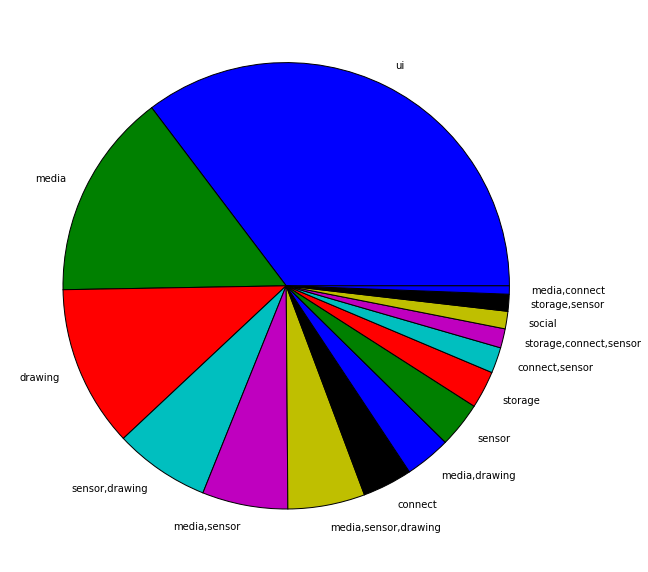

In [227]:
count = df['palette_groups'].value_counts()
print count
count.head(15).plot(kind='pie', subplots=True, figsize=(10,10))

In [226]:
NUM_PROJS = len(df)
# for key in count.keys:
#     count[keys] = count[keys] / NUM_PROJS
sum=0
i = 0;
for key, val in count.iteritems():
    if i<15:
        sum+=val
    i=i+1
    print key + "\t\t\t" + str(float(val)/NUM_PROJS)
#     "%.2f" % a
print i
print sum
print float(sum)/NUM_PROJS

ui			0.325363427697
media			0.138102524866
drawing			0.107880642693
sensor,drawing			0.0638867635807
media,sensor			0.0571920428462
media,sensor,drawing			0.0514537107881
connect			0.0332823259373
media,drawing			0.0306044376435
sensor			0.0304131599082
storage			0.0250573833206
connect,sensor			0.0172149961744
storage,connect,sensor			0.0128156082632
social			0.0116679418516
storage,sensor			0.011285386381
media,connect			0.00554705432288
media,social			0.00439938791125
storage,connect			0.00439938791125
media,storage,sensor,drawing			0.00439938791125
media,storage,connect,sensor			0.00420811017598
storage,drawing			0.0040168324407
media,storage,sensor			0.0040168324407
media,storage			0.00382555470543
media,connect,sensor			0.00363427697016
media,storage,social,sensor			0.00344299923489
storage,social			0.00306044376435
storage,sensor,drawing			0.00229533282326
media,storage,drawing			0.00229533282326
connect,social,sensor			0.00210405508799
media,social,sensor			0.00191277735272
med

In [205]:
"%.2f" % 12.3543234

'12.35'